<a href="https://colab.research.google.com/github/anvesh-lp/BruteForce/blob/main/DataOptimizationGOOGLE_usingRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd #Data manipulation and analysis
import numpy as np #Numerical computing
import matplotlib.pyplot as plt #Data Visualzation
import seaborn as sns #Data Visualzation
import time #Various time-related functions

In [16]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
#Settings for appropriate display  

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [88]:
#Ignoring all warning ⚠ messages thrown

import warnings
warnings.filterwarnings('ignore')

In [89]:
import pandas_datareader as pdr #Remote data access for pandas
from datetime import date

df = pdr.DataReader('GOOG', data_source='yahoo', start='2016-01-01', end = "2021-12-31")
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,37.202999,36.562901,37.150002,37.091999,65456000,37.091999
2016-01-05,37.599998,36.931999,37.322498,37.129002,39014000,37.129002
2016-01-06,37.359001,36.445999,36.500000,37.181000,38940000,37.181000
2016-01-07,36.924999,35.952999,36.515499,36.319500,59274000,36.319500
2016-01-08,36.661499,35.650002,36.572498,35.723499,49018000,35.723499


In [90]:
df = df["Close"]
df = pd.DataFrame(df)
df.head()

,Close
Date,
2016-01-04,37.091999
2016-01-05,37.129002
2016-01-06,37.181000
2016-01-07,36.319500
2016-01-08,35.723499


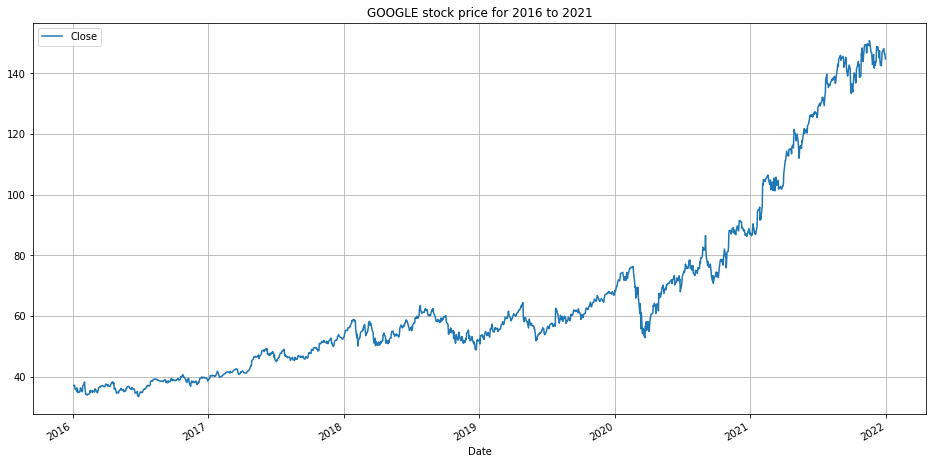

In [91]:
df.plot(figsize=(16,8), title = "GOOGLE stock price for 2016 to 2021", grid = True)

In [92]:
%matplotlib inline
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [93]:
data = df

In [94]:
train_data = data[2:500] 
test_data = data[500:] 
train = train_data.values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [95]:
from numpy.random import seed
seed(2019)

model = Sequential()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

In [96]:
# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
%time model.fit(X_train, y_train, epochs = 40, batch_size = 40)

Epoch 1/40
13/13 [==============================] - 9s 20ms/step - loss: 0.1368
Epoch 2/40
13/13 [==============================] - 0s 25ms/step - loss: 0.0436
Epoch 3/40
13/13 [==============================] - 0s 24ms/step - loss: 0.0179
Epoch 4/40
13/13 [==============================] - 0s 21ms/step - loss: 0.0074
Epoch 5/40
13/13 [==============================] - 0s 27ms/step - loss: 0.0074
Epoch 6/40
13/13 [==============================] - 0s 21ms/step - loss: 0.0055
Epoch 7/40
13/13 [==============================] - 0s 22ms/step - loss: 0.0058
Epoch 8/40
13/13 [==============================] - 0s 22ms/step - loss: 0.0057
Epoch 9/40
13/13 [==============================] - 0s 22ms/step - loss: 0.0066
Epoch 10/40
13/13 [==============================] - 0s 22ms/step - loss: 0.0059
Epoch 11/40
13/13 [==============================] - 0s 22ms/step - loss: 0.0052
Epoch 12/40
13/13 [==============================] - 0s 23ms/step - loss: 0.0056
Epoch 13/40
13/13 [==================

In [97]:
# this will be used later while comparing and visualization

real_stock_price = test_data.iloc[:,0:1].values # taking open price

In [98]:
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Close'], test_data['Close']), axis = 0)

# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [99]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

32/32 [==============================] - 2s 6ms/step


In [100]:
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean Square Error (MSE): '+str(mean_squared_error(real_stock_price, predicted_stock_price)))
print('Mean Absolute Error(MAE): '+str(mean_absolute_error(real_stock_price, predicted_stock_price)))
print('Root Mean Square Error (RMSE): '+str(math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))))

Mean Square Error (MSE): 909.5668962999504
Mean Absolute Error(MAE): 17.748948449079172
Root Mean Square Error (RMSE): 30.159026779721362


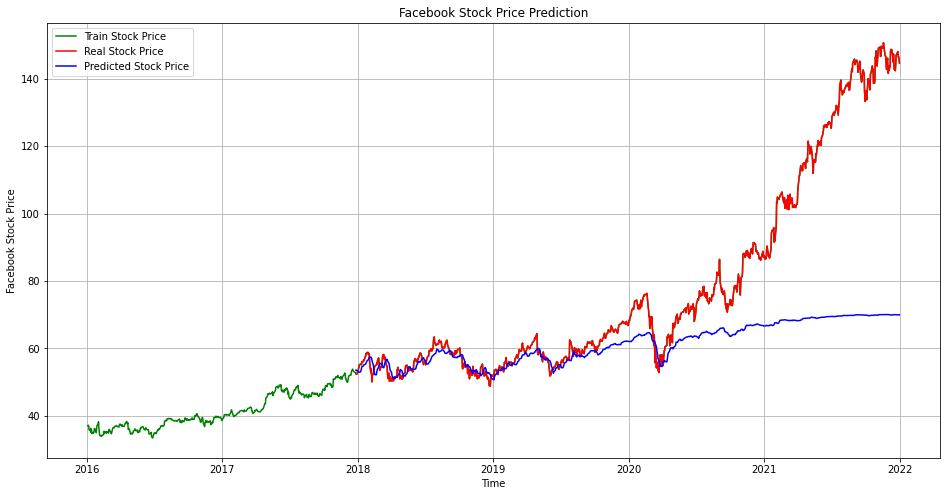

In [101]:
#Visualize entire data

plt.figure(figsize=(16,8))
plt.plot(data.index, data['Close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Facebook Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.grid(True)
plt.show()

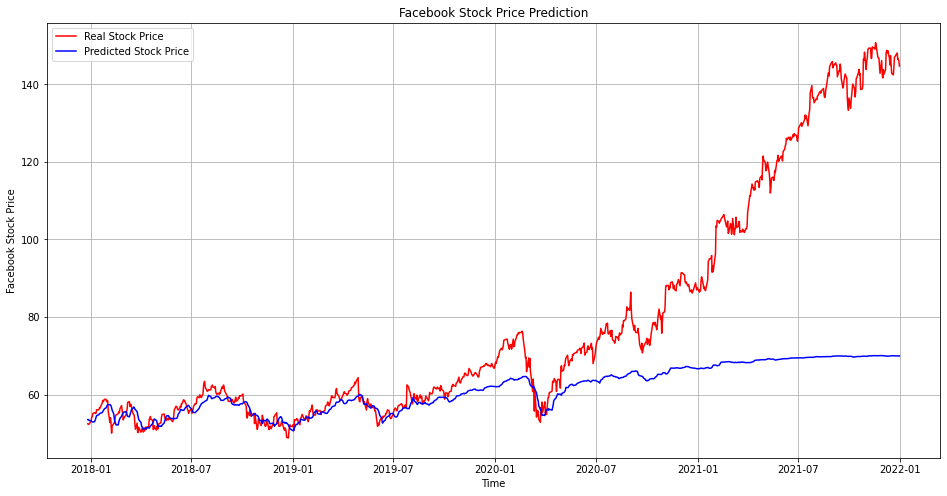

In [103]:
#Visualize the test data

plt.figure(figsize=(16,8))
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Facebook Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.grid(True)
plt.show()